In [235]:
import datetime
import sys
import os
import pandas as pd
import numpy as np
import telegram
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tinvest import SyncClient
from telegram import Bot
sys.path.append("..")
from stats import get_assets_df_for_period

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
def split_by_dt(df: pd.DataFrame, split_dt: datetime.date = None, test_share: float = None) -> tuple:
    df = df.sort_values("dt")
    if split_dt is not None:
        return df[df.dt <= split_dt], df[df.dt > split_dt]
    elif test_share is not None:
        count = df.shape[0]
        test = df.tail(int(test_share * count))
        train = df[~df.index.isin(test.index)]
        return train, test

In [156]:
TINKOFF_OPEN_API_TOKEN = "OPEN_API_TOKEN"
TELEGRAM_BOT_TOKEN = "TELEGRAM_BOT_TOKEN"

In [169]:
markets = client.get_market_stocks()
markets.payload.instruments = markets.payload.instruments[:80]

In [246]:
bot = Bot(token=os.getenv(TELEGRAM_BOT_TOKEN))
client = SyncClient(os.getenv(TINKOFF_OPEN_API_TOKEN))
days_to_analyze = 365 * 4
date_to = datetime.datetime.now()
date_from = date_to - datetime.timedelta(days=days_to_analyze)

markets = client.get_market_stocks()
markets.payload.instruments = markets.payload.instruments[:80]
grouped_by_dt_candles = get_assets_df_for_period(client, markets, date_from, date_to, sleep_seconds=30)

100%|██████████| 80/80 [01:30<00:00,  1.14s/it]


In [247]:
grouped_by_dt_candles

,name,figi,currency,closed,dt
0,InterDigItal Inc,BBG000HLJ7M4,usd,77.3167,2018-01-26
1,InterDigItal Inc,BBG000HLJ7M4,usd,77.2678,2018-01-29
2,InterDigItal Inc,BBG000HLJ7M4,usd,77.7074,2018-01-30
3,InterDigItal Inc,BBG000HLJ7M4,usd,76.2422,2018-01-31
4,InterDigItal Inc,BBG000HLJ7M4,usd,76.6329,2018-02-01
...,...,...,...,...,...
64006,Take-Two Interactive Software,BBG000BS1YV5,usd,155.8600,2022-01-18
64007,Take-Two Interactive Software,BBG000BS1YV5,usd,163.5300,2022-01-19
64008,Take-Two Interactive Software,BBG000BS1YV5,usd,162.2300,2022-01-20
64009,Take-Two Interactive Software,BBG000BS1YV5,usd,164.9900,2022-01-21


In [249]:
grouped_by_dt_candles.groupby(["name", "figi"]).count().sort_values("dt")

,,currency,closed,dt
name,figi,,,
Twist Bioscience,BBG006KDCHJ4,19,19,19
3D Systems Corp,BBG000D42FJ0,62,62,62
"Shoals Technologies Group, Inc.",BBG00YQ82275,152,152,152
"Coursera, Inc.",BBG002WLDMW5,185,185,185
Coinbase,BBG00ZGF7771,198,198,198
...,...,...,...,...
Московская Биржа,BBG004730JJ5,1010,1010,1010
ПАО «КАЗАНЬОРГСИНТЕЗ»,BBG0029SFXB3,1010,1010,1010
ТГК-2,BBG000Q7GG57,1010,1010,1010


In [250]:
figi_exmaple = grouped_by_dt_candles[grouped_by_dt_candles.figi == "BBG000BR2B91"]

In [251]:
train, test = split_by_dt(figi_exmaple, test_share=0.2)

In [252]:
train = train.reset_index()
test = test.reset_index()

In [256]:
model = Prophet(weekly_seasonality=False)
model.fit(train.rename(columns={"dt": "ds", "closed": "y"}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [263]:
import datetime

In [264]:
datetime.date(2021, 5, 4).strftime("%Y-%m")

'2021-05'

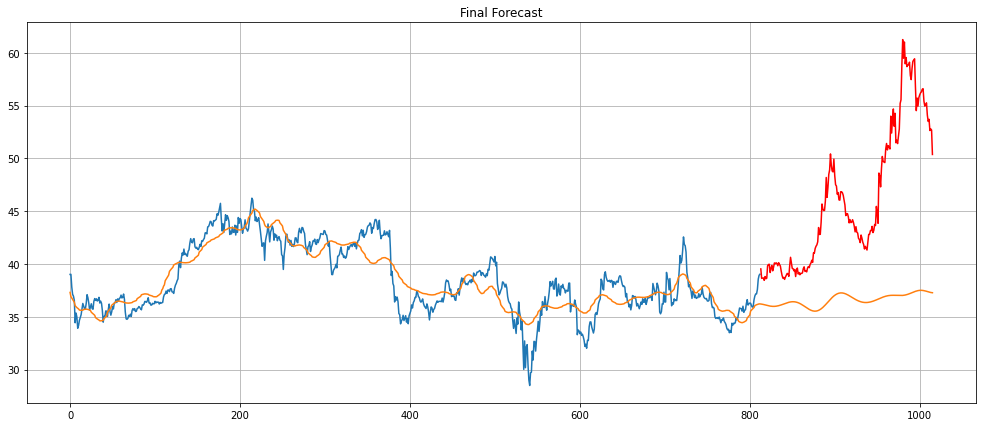

In [262]:
# Forecast
n_periods = test.shape[0]
future = model.make_future_dataframe(periods=n_periods)
future.tail()
forecast = model.predict(future)

# Plot
plt.figure(figsize=(17, 7))
plt.grid()
plt.plot(train.closed)
plt.plot(forecast['yhat'])
plt.plot(np.arange(test.shape[0]) + len(train.closed), test.closed, label="forecast", color='red')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast")
plt.show()

In [257]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)